In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.linalg.lapack import zggev
from scipy.linalg import block_diag
import pandas as pd
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from direct_effect_analysis import * 
from utils import *
from mvlearn.embed import GCCA
from pgmpy.estimators import PC
from plotnine import ggplot, aes, geom_line, geom_ribbon, scale_x_log10, scale_x_continuous, labs, theme, facet_wrap, ggsave, theme_bw, element_text

In [2]:
algorithms = ['PCA', 'gCCA', 'T_D', 'T_F', 'T_F']
B_conds = ['d', '1', '1/d', '1/d^2']
Sigma_conds = ['d', '1', '1/d', '1/d^2']
results = {B_cond:{Sigma_cond:{algo: {} for algo in algorithms } for Sigma_cond in Sigma_conds} for B_cond in B_conds} 

In [3]:
p, r, d, q, rk = 10, 10, 100, 1, 10
N = 4000
dimensions = [2, 5, 10, 20, 50, 100, 200, 500]

In [4]:
a, b, c = 0.1, 0.1, 0.8
B = 20
for B_cond in tqdm(B_conds):
    for Sigma_cond in Sigma_conds:
        for algo in algorithms:
            # print(noise, algo)
            CORRS = []
            for d in dimensions:
                d = int(d)
                CORR = []
                for j in range(B):

                    # Generate parameters
                    _, A_z, beta, gamma = parameters(r, p, q, d, False)

                    if B_cond == 'd':
                        A_x = np.array([i for i in range(d)])[:, None].T
                    elif B_cond == '1':
                        A_x = np.array([1 for i in range(d)])[:, None].T
                    elif B_cond == '1/d':
                        A_x = np.array([1/(i+1) for i in range(d)])[:, None].T
                    elif B_cond == '1/d^2':
                        A_x = np.array([1/((i+1)**2) for i in range(d)])[:, None].T

                    if Sigma_cond == 'd':
                        Sigma = np.diag(np.array([i for i in range(d)]))
                    elif Sigma_cond == '1':
                        Sigma = np.identity(d)
                    elif Sigma_cond == '1/d':
                        Sigma = np.diag(np.array([1/(i+1) for i in range(d)]))
                    elif Sigma_cond == '1/d^2':
                        Sigma = np.diag(np.array([1/((i+1)**2) for i in range(d)]))


                    # Generate training and test data
                    X_train, Y_train, Z_train, Y_x_train = generate_data_Sigma(N, p, r, d, beta, gamma, A_x, A_z, Sigma, a=a, b=b, c=c)
                    dea = DirectEffectAnalysis(type=algo, alpha=1e-5)
                    dea.fit(X_train, Y_train, Z_train)
                    Y_hat = dea.transform(X_train, Y_train, Z_train)
                    corr = np.abs(np.corrcoef(Y_hat, Y_x_train[:,0])[0, 1])
                    
                    # Compute MSE for each iteration
                    CORR.append(corr)
                CORRS.append(CORR)
            # Append MSE for current sample size
            results[B_cond][Sigma_cond][algo] = CORRS

100%|██████████| 4/4 [17:40<00:00, 265.14s/it]


/tmp/ipykernel_1496/3030442696.py:56: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


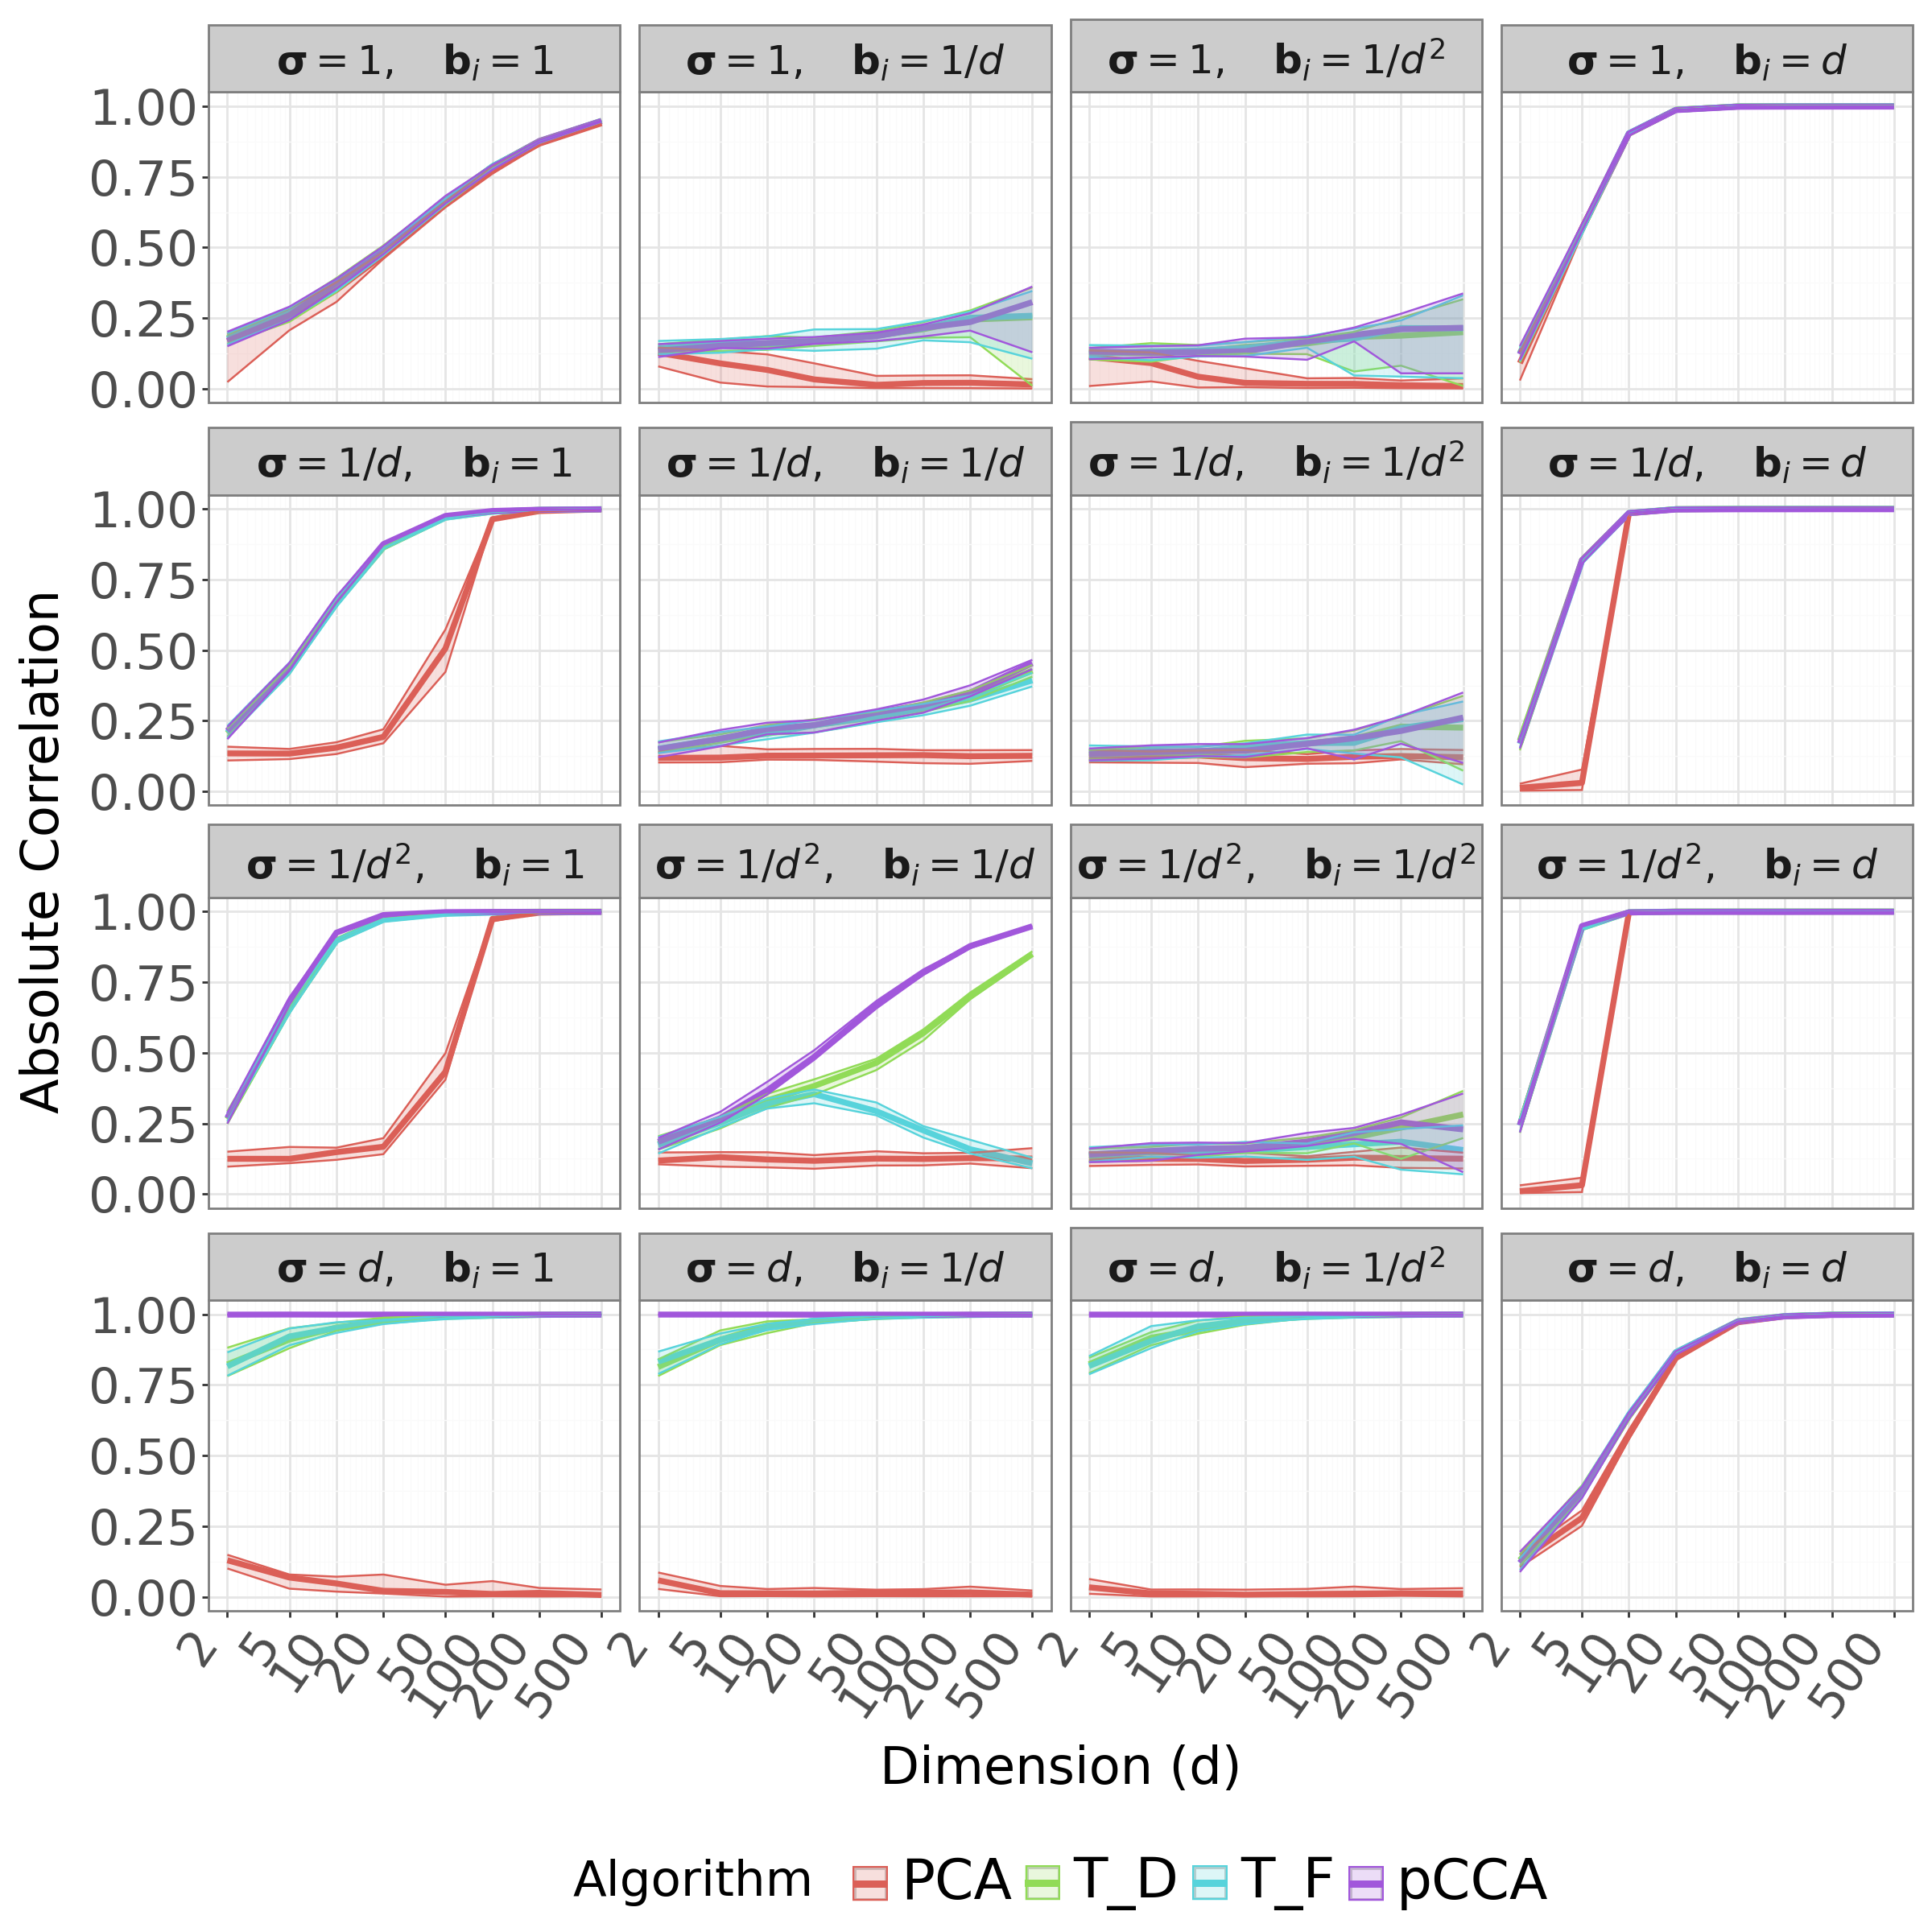

In [5]:
# Assuming you have the following data structures
algo_names = {'PCA':'PCA', 'gCCA':'pCCA', 'T_F':'T_F', 'T_S':'T_S', 'T_D':'T_D'}
# results, B_conds, Sigma_conds, algorithms, dimensions are defined elsewhere

# Prepare data for ggplot
data = []
for B_cond in B_conds:
    for Sigma_cond in Sigma_conds:
        for algo in algorithms:
            algo_data = results[B_cond][Sigma_cond][algo]
            values = np.array(algo_data)
            median = np.percentile(values, 50, axis=1)
            lower = np.percentile(values, 5, axis=1)
            upper = np.percentile(values, 95, axis=1)
            
            for i, dim in enumerate(dimensions):
                data.append({
                    'Dimension': dim,
                    'Median': median[i],
                    'Lower': lower[i],
                    'Upper': upper[i],
                    'Algorithm': algo_names[algo],
                    'Sigma': Sigma_cond,
                    'B': B_cond  # Add weight name to the data
                })

# Create a DataFrame
df = pd.DataFrame(data)
# df2 = df[df['Algorithm']!='PCA']
df2 = df

# Create a new column for the facet label
df2['Facet_Label'] = '$\\mathbf{\\sigma}=' + df2['Sigma'].astype(str) + ',\\hspace{1} \\mathbf{b}_i=' + df2['B'].astype(str) + '$'

# Adjusted plot with 45-degree rotated x-axis labels
p = (ggplot(df2, aes(x='Dimension', y='Median', color='Algorithm', fill='Algorithm'))
     + geom_line(size=1.5)
     + geom_ribbon(aes(ymin='Lower', ymax='Upper'), alpha=0.2)
     + scale_x_log10(breaks=dimensions)  # Set specific x-axis ticks to log scale
     + labs(x='Dimension (d)', y='Absolute Correlation')
     + facet_wrap('~Facet_Label', ncol=4)  # Use the new Facet_Label for facets
     + theme_bw()  # Apply black-and-white theme
     + theme(
         legend_position='bottom', 
         figure_size=(12, 12),
         axis_title=element_text(size=23),  # Increase axis title size
         axis_text=element_text(size=22),   # Increase axis tick text size
         axis_text_x=element_text(angle=55, hjust=1),  # Rotate x-axis labels by 45 degrees
         legend_title=element_text(size=22),  # Increase legend title size
         legend_text=element_text(size=25),
         strip_text=element_text(size=18)  # Increase legend text size
     )
)

# Display the plot
print(p)
